In [1]:
%%capture

import ROOT
import os
from dask.distributed import Client
#from utils import *
import logging

logger = logging.getLogger(__name__)
logging.disable('WARNING')

#ROOT.RDF.Experimental.Distributed.open_files_locally = False

nmaxpartitions = 3
sched_port = 21539

In [2]:
client = Client(address="tcp://127.0.0.1:"+str(sched_port))

/usr/local/lib/python3.8/dist-packages/distributed/client.py:1128: VersionMismatchWarning: Mismatched versions found

+---------+--------+-----------+---------+
| Package | client | scheduler | workers |
+---------+--------+-----------+---------+
| msgpack | 1.0.3  | 1.0.2     | 1.0.3   |
| toolz   | 0.11.2 | 0.11.1    | 0.11.2  |
+---------+--------+-----------+---------+
Notes: 
-  msgpack: Variation is ok, as long as everything is above 0.6
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


# Import utils functions

In [3]:
text_file = open("utils.h", "r")
data = text_file.read()


def my_initialization_function():
    ROOT.gInterpreter.Declare('{}'.format(data))
    #from urllib import request
    #modelName = "dummy_pyHEP"
    #request.urlretrieve("https://vbs-pg-support.web.cern.ch/models/{}.hxx".format(modelName), "{}.hxx".format(modelName))
    #request.urlretrieve("https://vbs-pg-support.web.cern.ch/models/{}.dat".format(modelName), "{}.dat".format(modelName))
    #ROOT.gInterpreter.Declare('#include "' + modelName + '.hxx"')
    #ROOT.gInterpreter.Declare('auto sofie_functor = TMVA::Experimental::SofieFunctor<5,TMVA_SOFIE_'+modelName+'::Session>(0);')


client = Client(address="tcp://127.0.0.1:"+str(sched_port))
ROOT.RDF.Experimental.Distributed.initialize(my_initialization_function)

# Define samples to be analyzed

In [4]:
chain = "root://eospublic.cern.ch//eos/root-eos/cms_opendata_2012_nanoaod/ZZTo2e2mu.root"

# Do analysis

In [5]:
h = {}

In [6]:
#df = ROOT.RDataFrame("Events", chain)   
df = ROOT.RDF.Experimental.Distributed.Dask.RDataFrame("Events", chain, npartitions=nmaxpartitions, daskclient=client)   

h = df.Vary("Muon_pt", "ROOT::VecOps::RVec<ROOT::VecOps::RVec<float>>{Muon_pt*0.8, Muon_pt*1.2}", variationTags=["down", "up"], variationName="dummyVariation")\
      .Define("SelectedMu_pt", "Muon_pt[0]")\
      .Filter("SelectedMu_pt > 30", "Filter on muons")\
      .Histo1D(("SelectedMu_pt", "" , 10, 30, 130), "SelectedMu_pt")
     #.Define("SMmodel", "sofie_functor(rdfslot_, Muon_pt[0], Muon_eta[0] , Electron_pt[0], Electron_eta[0])")\

/usr/local/lib/python3.8/dist-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [7]:
#h_varied = ROOT.RDF.Experimental.VariationsFor(h)
h_varied = ROOT.RDF.Experimental.Distributed.VariationsFor(h)

# Save histos

CPU times: user 4 µs, sys: 2 µs, total: 6 µs
Wall time: 9.06 µs


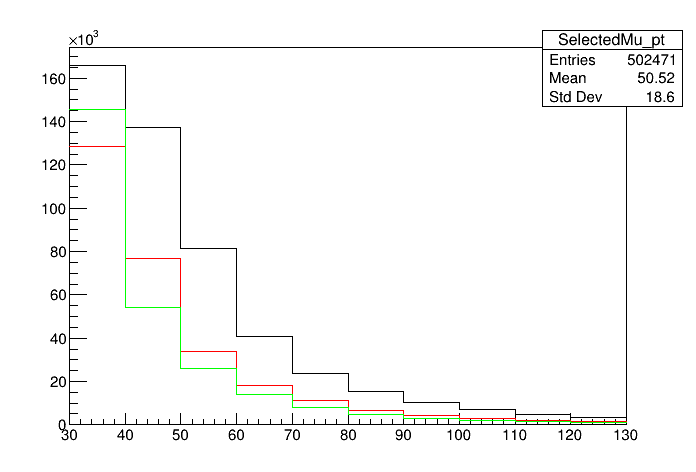

In [8]:
%time
c = ROOT.TCanvas()
h_varied["dummyVariation:up"].SetLineColor(1)
h_varied["dummyVariation:up"].Draw()
h_varied["nominal"].SetLineColor(2)
h_varied["nominal"].Draw('SAME')
h_varied["dummyVariation:down"].SetLineColor(3)
h_varied["dummyVariation:down"].Draw('SAME')
c.Draw()